In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from qnetwork.tools import set_plot_style
from scipy.signal import correlate
from qnetwork.multiphoton_ww import EmittersInWaveguideMultiphotonWW
from typing import Optional

set_plot_style()

# Two qubits in a cavity 

I want to make sure I can use the analytical solution of the DDE to look at two qubits in a cavity 

In [ ]:
from aux_funs import DDE_analytical



def two_qubits_analytical(t_max: float = 20,
						  n_steps: int = 201,
						  gamma: float = 0.1,
						  phi: float = 2*np.pi, 
						  L:float =1,
						  c: float = 1,
						  initial: np.ndarray = np.asarray([0,1,0,0])):
	tau = 2*L/c
	t = np.linspace(0,t_max,n_steps)
	b = np.asarray([[0,0],[1,0]])
	b1 = np.kron(b,np.eye(2))
	b2 = np.kron(np.eye(2),b)

	#c_plus = DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t)
	#c_minus = DDE_analytical(gamma=gamma,phi=phi + np.pi,tau=tau,t=t)
	c_plus = dde_series(gamma=gamma,tau=tau,eta=np.exp(1j*phi),t=t)
	c_minus = dde_series(gamma=gamma,tau=tau,eta=-np.exp(1j*phi),t=t)



	sum = 0.5*(c_plus+c_minus)
	dif = 0.5*(c_plus-c_minus)

	pop1 = (np.abs(sum)**2)*np.dot(initial,b1.T@b1@initial).astype(complex)
	pop1+= np.conjugate(sum)*dif*np.dot(initial,b1.T@b2@initial)
	pop1+= np.conjugate(dif)*sum*np.dot(initial,b2.T@b1@initial)
	pop1+= (np.abs(dif)**2)*np.dot(initial,b2.T@b2@initial)

	pop2 = (np.abs(dif)**2)*np.dot(initial,b1.T@b1@initial).astype(complex)
	pop2+= np.conjugate(dif)*sum*np.dot(initial,b1.T@b2@initial)
	pop2+= np.conjugate(sum)*dif*np.dot(initial,b2.T@b1@initial)
	pop2+= (np.abs(sum)**2)*np.dot(initial,b2.T@b2@initial)
	return t,[np.abs(pop1),np.abs(pop2)]



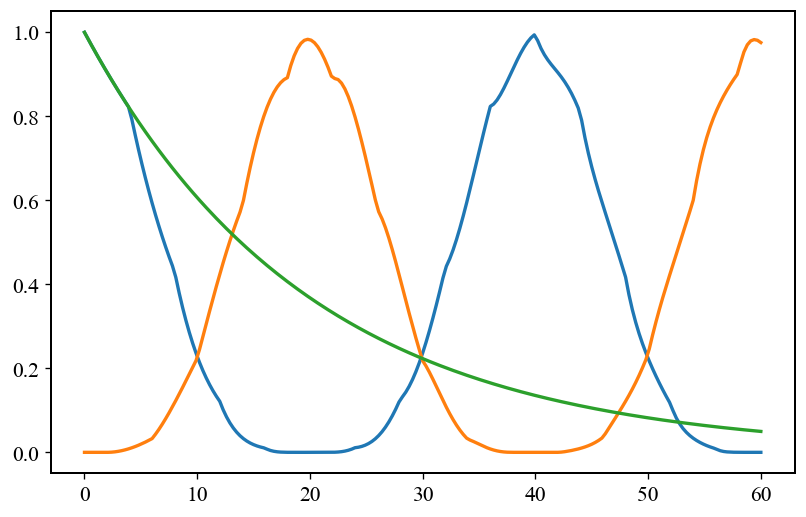

In [54]:
t,pop = two_qubits_analytical(phi=np.pi,gamma=0.05,initial=[0,1,0,0],t_max=60)
plt.plot(t,pop[0])
plt.plot(t,pop[1])
plt.plot(t,np.exp(-0.05*t))
plt.grid()
plt.show()

In [38]:
from expt_sets import expt_001_dynamics

expt_001_dynamics(Delta = 2 , gamma=0.1,tau=2)

0.0


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

# Characterization of Rabi-Like behavior 

The points to show in this section are 
1. The DDE contain Rabi physics 
2. The Rabi oscillations are 'protected' by symmetry in high energetic modes of the coupling 

In [ ]:
def run_ww_simulation(t_max: Optional[float] = None , gamma :float = 0.1, Delta: float = 10.0 , L:float = 1, c: float = 1, n_steps: int = 201,n_modes=20):
	tau=2*L/c
	if t_max is None:
		t_max = 25*tau 
	setup=EmittersInWaveguideMultiphotonWW(gamma=gamma,Delta=Delta,L=L,c=c,positions=[0.0], n_modes=n_modes, n_excitations=list(range(2)))
	t,e = setup.evolve(t_max,n_steps=n_steps,initial_state="1")
	return t,e

def run_dde_simulation(t: list|np.ndarray , gamma :float = 0.1, tau: float=2,phi: float = 10.0,):
	return np.abs(DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t))**2


In [ ]:
from scipy.signal import find_peaks

def exp003(t_max: Optional[float] = None , gamma :float = 0.1, Delta: float = 10, L:float = 1, c: float = 1, n_steps: int = 201,plot_bool:bool =True): 

	t = np.linspace(0,t_max,n_steps)
	phi = 2*np.pi*Delta
	tau = 2*L/c
	e_dde = run_dde_simulation(t=t,gamma=gamma,tau=tau,phi=phi)
	e_rabi = np.cos(np.sqrt(gamma/tau)*t)**2
	# if I am not mistaken, this is the correlation
	dt = t[1]-t[0] 

	corr = correlate(e_dde-np.mean(e_dde),e_dde-np.mean(e_dde))
	corr_positive = corr[t.shape[0]-1:]
	corr_positive=corr_positive/corr_positive[0]
	peaks_corr,_=find_peaks(corr_positive)
	
	correlation_times=corr_positive[peaks_corr]

	corr_rabi = correlate(e_rabi-np.mean(e_rabi),e_rabi-np.mean(e_rabi))
	corr_rabi_positive = corr_rabi[t.shape[0]-1:]
	corr_rabi_positive = corr_rabi_positive/corr_rabi_positive[0]
	peaks_corr_rabi,_=find_peaks(corr_rabi_positive)
	if plot_bool:
		plt.plot(t/tau,corr_positive,label='DDE')
		plt.plot((t/tau)[peaks_corr],correlation_times,'o')
		
		plt.plot(t/tau,corr_rabi_positive,'r--',label='Rabi')
		plt.plot((t/tau)[peaks_corr_rabi],corr_rabi_positive[peaks_corr_rabi],'o')
		
		plt.axvline(np.pi/np.sqrt(gamma*tau),color='k',linestyle='-.',alpha=0.5,label=r'$\frac{\pi}{\sqrt{\gamma \tau}}$')
		plt.grid()
		plt.legend()
		plt.xlabel(r"$t/\tau$")
		plt.show()
	return t[peaks_corr][0]

#def exp004(t_max: Optional[float] = None , gamma :float = 0.1, Delta: float = 10, L:float = 1, c: float = 1, n_steps: int = 201,n_modes=20,plot_bool:bool =True): 

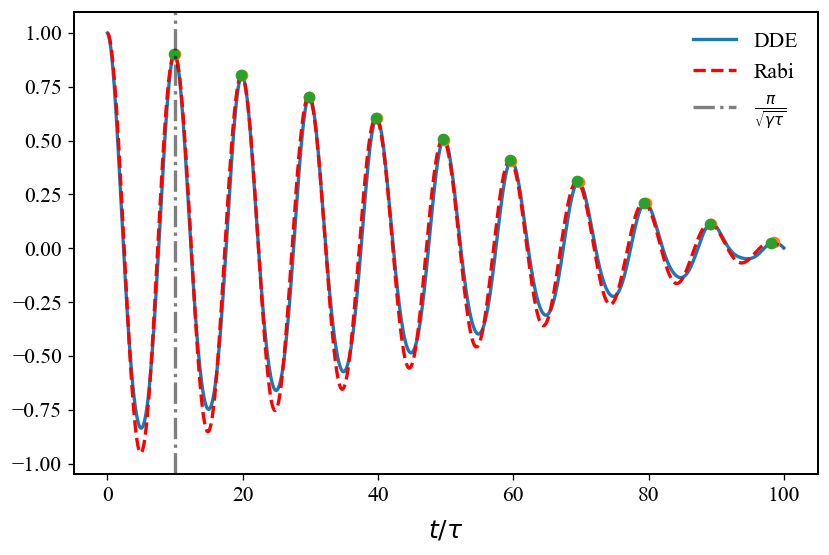

np.float64(19.84)

In [103]:
exp003(gamma=0.05,t_max=200,n_steps=2501)